# Project 2 report

*You can delete this cell, and add new cells to put your code and write your report.*

*To add a new code or Markdown cell, click the <kbd>+</kbd> button in the toolbar. By default, this will be a code cell; to change it to Markdown, click the drop-down menu in the toolbar which says <kbd>Code</kbd>, and select <kbd>Markdown</kbd> in the list.*

*To format the text in a Markdown cell, just run the cell. To edit it again, double-click on it. For examples of Markdown formatting, you can double-click on any Markdown cell in any of the course notebooks. For instance, there are lots of examples at the top of the Week 1 tutorial notebook.*

***Group 28 project 2 report***

The aim of this project is to look at and analyse data from the NYC yellow taxi cabs. Namely, looking at tips and payment types. Below are the 4 topics we looked at:
1. The change of payment type from cash to card over the years.
2. The frequency of disputed taxi fares in all 265 taxi zones in NYC.
3. The average tipping in each taxi zone. 
4. Tip distrubution by time of day.   

 

In [1]:
import pandas as pd
import geopandas as gpd
import geopandas 
from geopandas import GeoDataFrame as gdf

# Import the function get_taxi_data() from utils.py
from utils import get_taxi_data
import os
import numpy as np
import matplotlib.pyplot as plt
#Packages to display to dataframes side by side
from IPython.display import display_html
from itertools import chain,cycle


In [2]:
#Import relevant file for creating the taxi zone maps, and rename the zone map column to match the one used in df
#NYC Taxi Zones shape file for geopandas was obtained from https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc , Nov 2022

nyc_map = gpd.read_file("NYC Taxi Zones/geo_export_d2c2431e-59a9-4f35-9b79-61a75848e709.shp")
nyc_map = nyc_map.rename(columns={'location_i':'PULocationID'})
nyc_map

,borough,PULocationID,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...,...,...
258,Brooklyn,256.0,256.0,0.000169,0.067915,Williamsburg (South Side),"POLYGON ((-73.95834 40.71331, -73.95681 40.712..."
259,Bronx,259.0,259.0,0.000395,0.126750,Woodlawn/Wakefield,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
260,Queens,260.0,260.0,0.000422,0.133514,Woodside,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
261,Manhattan,261.0,261.0,0.000034,0.027120,World Trade Center,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."


In [3]:
def get_data_month(year,month):
    '''
    The function downloads the data for the inputted year and year.
    The data is from the get_taxi_data function. Yellow taxi data only.
    It takes columns: pickup and dropoff time, number of passenger, trip distance, fare 
    and tip amount, and type of payment.
    It removes any date and time outliers.
    '''
    
    #Define the number of days in month (not leap year)
    days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]
    
    #Create an empty dataframe
    df_raw = pd.DataFrame()
    
    #Selecting columns to download
    cols_to_read = ['tpep_pickup_datetime',
                    'tpep_dropoff_datetime',
                    'passenger_count',
                    'trip_distance',
                    'fare_amount',
                    'tip_amount',
                    'payment_type',
                    'PULocationID']
   
    #Looping years range
    #Check if year is a leap year, if True then the number of days in February is 29
    if year % 4 == 0:
        days_in_month[1] = 29
    else:
        days_in_month[1] = 28

    #No data later than August 2022, so loop stops
    if year >= 2022 and month >= 9:
        return

    month_as_str = str(month).zfill(2)
    
    #calling get taxi function for month and year inside the loop
    df_get_taxi = get_taxi_data(str(year), month_as_str, 'yellow', columns = cols_to_read)
    
    # Remove the date outside the range of each month for the pickup datetime column
    # Remove the date before the start of the month and 2 hours after the start of the next month
    df_get_taxi = df_get_taxi[(df_get_taxi['tpep_pickup_datetime'] > f"{year}-{str(month_as_str)}-01 00:00:00") &
                    (df_get_taxi['tpep_pickup_datetime'] < f"{year}-{str(month_as_str)}-{days_in_month[month-1]} 23:59:59")]
    
    #Remove the data before the start of the month
    df_get_taxi = df_get_taxi[(df_get_taxi['tpep_dropoff_datetime'] > f"{year}-{str(month_as_str)}-01 00:00:00")]

    #If the month is not December, then remove the data after 2 hours at the start of the next month
    if month in range(1,9):
        df_get_taxi =  df_get_taxi[(df_get_taxi['tpep_dropoff_datetime'] < f"{year}-0{month + 1}-01 02:00:00")]

    elif month in range(9,12):
        df_get_taxi =  df_get_taxi[(df_get_taxi['tpep_dropoff_datetime'] < f"{year}-{month + 1}-01 02:00:00")]

    #If the month is December, then also includes the first 2 hours of the 1st January in the next year
    else:
        df_get_taxi =  df_get_taxi[(df_get_taxi['tpep_dropoff_datetime'] < f"{year+1}-01-01 02:00:00")]

    #Adding each month of data to the data frame by concatenation
    df_raw = pd.concat([df_raw, df_get_taxi])
                                        
    return df_raw

In [4]:
def clean_data(start_year, end_year, df_raw=None): 
  """
  Cleans the data retrieved from the get_data function.
  It does this by removing rows where the columns
  tip_amount, passenger_count, trip_distance, fare_amount, payment_type
  values are not in our desired range
  If single_month is True then end_year is the month of data to extract
  """
  #reads csv from get data function
  if type(df_raw) == type(None):
    df_raw = get_data(start_year, end_year)

  #Drop any row with NaN Value
  df_raw = df_raw.dropna(how="any")
  
  #calculates the 99th percentile for the tip amount column
  tip_highprc = df_raw['tip_amount'].quantile(0.99)
  
  #calculates the 1st percentile for the trip distance column
  distance_lowprc = df_raw['trip_distance'].quantile(0.01)
  #calculates the 99th percentile for the trip distance column
  distance_highprc = df_raw['trip_distance'].quantile(0.99)
  
  #calculates the 99th percentile for the fare amount column
  fare_highprc = df_raw['fare_amount'].quantile(0.99)
  
  #This will drop all rows that have column values outside of our desired range
  #removes row when tip amount is negative or higher than 99th percentile
  df_raw = df_raw.drop(df_raw[(df_raw['tip_amount'] < 0)| (df_raw['tip_amount'] > tip_highprc) |
                      #removes row when passengers less than 1 or higher than 8
                      (df_raw['passenger_count'] < 1) | (df_raw['passenger_count'] > 8) |
                      #removes row when trip distance less than 1st percentile or higher than 99th percentile
                      (df_raw['trip_distance'] < distance_lowprc) | (df_raw['trip_distance'] > distance_highprc)|
                      #removes row when fare_amount is negative or higher than 99th percentile
                      (df_raw['fare_amount'] < 0) | (df_raw['fare_amount'] > fare_highprc)|
                      #removes row when the payment type not between 1 and 5 (6 is voided)
                      (df_raw['payment_type'] < 1) | (df_raw['payment_type'] > 5) |
                      #removes pickup location ID not in range 1-265
                      (df_raw['PULocationID'] < 1) | (df_raw['PULocationID'] > 265)].index)
  
  return df_raw


In [5]:
#naming each month
months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"]

In [6]:
def download_data(start_year, end_year, name):
    """
    The function saves the clean_data function as csv files for inputted years and selected columns
    The input name is to prevent duplications of names of folders
    """
# Check if data folder exists, if not create it
    if not os.path.exists(f"{name}"):
        os.mkdir(f"{name}")
    #looping for year in desired range
    for year in range(start_year, end_year):
        # Checks if year folder exists, if not create it
        if not os.path.exists(f"{name}/{year}"):
            os.mkdir(f"{name}/{year}")
        #looping for each month
        for month in range(1,13):
            #selecting name of month
            month_str = months[month-1]
            #cleans data using clean_data function then stores as csv
            clean_data(None, None, df_raw=get_data_month(year,month)).to_csv(f"{name}/{year}/{month_str}.csv", columns = use_cols, index = False)

***Part 1: Trend of Payment Types over time*** 


In this section we explore the trend of payments types cash vs card for yellow taxis over the years 2012 until August 2022
1. Read the csv files that downloaded the cleaned data from our get_taxi function for each month from 2012 to 2022
2. Sort the data into a dataframe that has the number of payment types for each month
3. Calculate the percentage of card payments for each month and display the trend over the years
4. Identify which months customers are more likely to pay cash or card

In [ ]:
#select columns to download
use_cols = ['tpep_pickup_datetime','payment_type']
#download data from 2012 to 2023 (30GB), all data is cleaned
download_data(2012, 2023, 'all_Data')

In [9]:
"""
This cell requires the 30GB of data to be downloaded, however, the dataframe produced in this cell has been saved as a csv file
the cells below can be run
"""
#create empty data frame
data = pd.DataFrame()
#loop for year between 2012 and 2022 and counts the frequency of each payment type per month
for year in range(2012,2023):
    # Checks if the year data folder exists before looping
    if os.path.exists(f"all_Data/{year}"):
        for month in range(1,13):
            #selecting month
            month_str = months[month-1]
            # Check that the month data csv file exists before reading the csv (opening a non-existent file causes errors)
            if os.path.exists(f"all_Data/{year}/{month_str}.csv"):
                #read the specific csv file
                cMonthData = pd.read_csv(f"all_Data/{year}/{month_str}.csv")
                #create new columns for year and month respectively
                cMonthData["year"] = pd.to_datetime(cMonthData['tpep_pickup_datetime']).dt.year
                cMonthData["month"] = pd.to_datetime(cMonthData['tpep_pickup_datetime']).dt.month

                #count each payment type per month
                gMonthData = cMonthData.groupby(['year','month','payment_type'])['payment_type'].size().unstack(fill_value=0)
                #add the counted payment type for each month to the dataframe
                data = pd.concat([data, gMonthData])
data.to_csv('payment_data.csv')

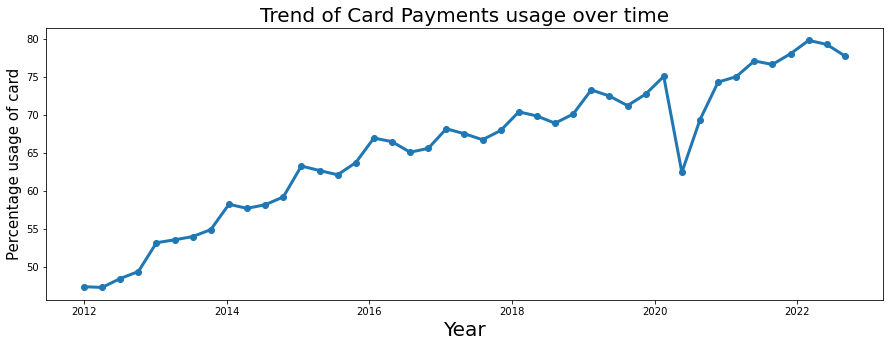

In [7]:
#read the csv file
data = pd.read_csv('payment_data.csv')
#calulate percentage of credit card payments to total payments
card_cash_prc = data.loc[:,'1' ] * 100 / (data.loc[:, '2'] + data.loc[:,'1' ])
#generate new column for calulcated percentages
data['perc'] = card_cash_prc
#create list for a 3 month average
mean_perc = []
#looping to average data every 3 months
for month in range(0,len(data), 3):
    mean_perc.append(np.mean(data.iloc[month : month + 3, -1]))

#set the figure size
f = plt.figure(figsize= (15,5))
#creating x axis from 2012 to august 2022
x = np.linspace(2012, 2022 + 8/12, len(mean_perc))
plt.plot(x, mean_perc,'-o', linewidth=3)
plt.title('Trend of Card Payments usage over time', fontsize = 20)
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Percentage usage of card', fontsize = 15)
plt.show()


There is a clear year on year increase in percenatage of card payments, with the expection of early 2020 which conincides exactly when the first outbreak of covid-19 happened, when the nation was in full-lockdown. Also, there seems to be cyclical peaks and troughs throughout each year. So next we will look at which months are higher than average and which months are lower than average.

([], [])

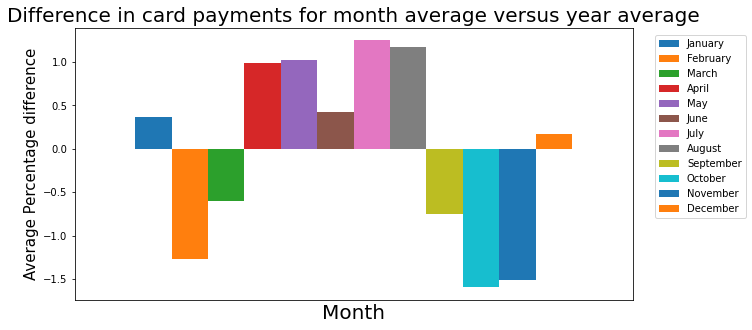

In [8]:
#drop payments types 3-5
data_next = data.drop(['3','4','5'], axis = 1)
#create empy list for average percentage of card payments per year 
perc_year = []
#create list for temporary average
temp_avg = []
index = 0
#looping every 12 months
for year in range(0,len(data),12):
    #looping in each month
    for month in range(0,12):
        #checking the month is in the data frame, if not it stops the loop
        if index >= len(data):
            break
        #stores the temporory average to the list
        temp_avg.append((data_next.iloc[index,-1]))
        index += 1
    #averages all month percenatges in year
    perc_year.append(np.mean(temp_avg))
    #reset temp_avg for next year
    temp_avg = []

#create list for the percentage different in each month
prc_diff = []
index = -1
#looping for each month in data frame
for month in range(len(data)):
    #checks month is in a new year if so the index goes to the next value
    if month % 12 == 0:
        index +=1
    #stores the percenatge difference between the month and the year average
    prc_diff.append(perc_year[index] - data.iloc[month , -1])

#store the list as a new column in dataframe
data_next['perc_diff'] = prc_diff
#create a pivot table that averages each month for all years then plot a bar chart 
data_next.pivot_table('perc_diff', columns = 'month', aggfunc= 'mean').plot.bar(figsize= (10,5), align = 'edge', width = 1.8)
#set legend & location of legend
plt.legend(loc = (1.04, 0.3) , labels = months)
plt.title('Difference in card payments for month average versus year average', fontsize = 20)
plt.ylabel('Average Percentage difference', fontsize = 15)
plt.xlabel('Month', fontsize = 20)
plt.xticks([])

Conclusion part 1: In the bar chart it shows that during the summer months April - August, December and January. This correlates with the the summer and winter holiday seasons. Therefore during the holiday seasons people are more likely pay by card.

***Part 2: Disputed zones***

In this part, we will try to find how many disputers in each area. We may recommend drivers to avoid the region which will have more disputers. Steps:
1. Calculate the  percentages of the disputed activities account for the whole payment activities in each location in 2021.
2. Then make a  map about it to show disputed areas .
3. Find out the most disputed place and do the recommendation and conclusion.

In [ ]:
#Download data for 2020 and 2021 related to payment type and tip amount
use_cols = ['tpep_pickup_datetime',
            'tpep_dropoff_datetime',
            'payment_type',
            'fare_amount',
            'PULocationID',
            'tip_amount']
download_data(2020, 2022, 'data')

In [11]:
"""
This cell requires 1.62GB of data to be downloaded, however, the dataframe produced in this cell is saved as a csv file
and referenced in the cells bellow.
"""

#add all months' individual csv files into a single csv file for the selected years

for year in range(2020,2022):
    if os.path.exists(f"data/{year}"):
        df = pd.DataFrame()
        for month in range(1,13):
            month_str = months[month-1]
            # Check that the month data csv file exists before reading the csv (opening a non-existent file causes errors)
            if os.path.exists(f"data/{year}/{month_str}.csv"):
                cMonthData = pd.read_csv(f"data/{year}/{month_str}.csv")
            #concat each month into the dataframe    
            df = pd.concat([df, cMonthData])
            df.to_csv(f"df_{year}.csv")    


In [12]:
"""
The output of this cell is already saved as a GeoDataFrame in the project folder.
"""

#get the data of the percentages use for each payment type 

#read the csv file
df_2021 = pd.read_csv('df.csv')

#drop na
df_2021['payment_type'].fillna(0).apply(pd.to_numeric)
#group the payment types by location ID & calculate % use for each payment type
pt = df_2021.groupby('PULocationID')['payment_type'].value_counts(normalize=True)*100
#only get the percentage of payment type 4 account for the whole payment type
pt2 = pt.loc[:,4]

#the code before will only show the locations which have disputed activities
pt2 = pd.DataFrame(pt2)
#need to add the zones with no values to get the complete map
per_disp = pd.DataFrame(np.zeros((266, 1)))
#location ID's range
per_disp['PULocationID']=range(0,266)
#if there is no data, give it the value of 0.00001
per_disp[0]=0.00001
#rename it
per_disp = per_disp.rename(columns={0: 'payment'})
# merge the data
for i in pt2.index:
    per_disp['payment'][i]=pt2['payment_type'][i]
per_disp = per_disp.drop([0])

#merge map file and payment type data frame using the "PULocationID" column
map_and_payment = nyc_map.merge(per_disp, on="PULocationID")
map_and_payment.sort_values(by=map_and_payment.columns[-1],axis=0,ascending=True,inplace=True)

#export GeoDataFrame
if not os.path.exists("map_and_payment"):
    os.mkdir("map_and_payment")
    map_and_payment.to_file('map_and_payment/map_and_payment.shp')  

/var/folders/zn/fhbk05j11q5854v0j9xqfxt00000gn/T/ipykernel_25858/2343277245.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_disp['payment'][i]=pt2['payment_type'][i]
/Users/Nico/opt/anaconda3/envs/pp-proj2/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/zn/fhbk05j11q5854v0j9xqfxt00000gn/T/ipykernel_25858/2343277245.py:39: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  map_and_payment.to_file('map_and_payment/map_and_payment.shp')


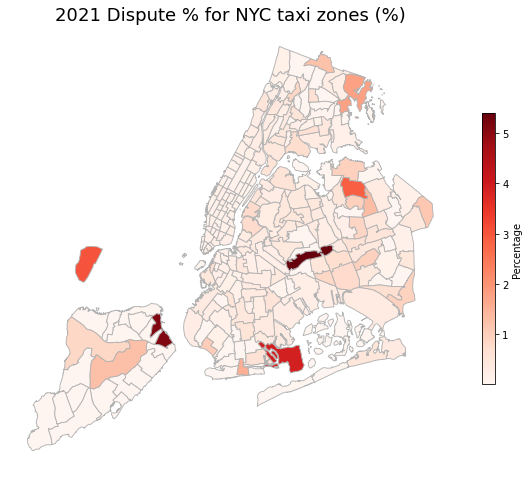

In [18]:
#read shp file
map_and_payment = gpd.read_file("map_and_payment/map_and_payment.shp")

#Plot heat map for the payment type4 in NY taxi zones
fig, ax = plt.subplots(1, figsize=(10, 10))
map_and_payment.plot(column="payment", cmap="Reds", linewidth=0.9, ax=ax, edgecolor="0.7")

#set bar with red gradient and set minimum and maximum values 
bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=map_and_payment['payment'].min(), vmax=map_and_payment['payment'].max()))
cbar = fig.colorbar(bar_info,shrink=0.5,label='Percentage')

#set figure tittle and remove axis coordinates
ax.set_title("2021 Dispute % for NYC taxi zones (%)",fontsize=18)
ax.set_axis_off()

***Conclusion of part 2:***
It is obvious that the highest disputors is in Forest Park/Highland Park(5.4%). The following one is in Stapleton(5.12%). If taxi drivers want to have higher tips or get the full reward normally, they can avoid these places.

***Part 3: Average tipping in each taxi zone.***

In this part, we will attempt to find which NY city taxi zones have the best tips on average.
1. Calculate the average tip in each taxi zone for the evaluated year(s).
2. Use geopandas to map the average tip to each taxi zone
3. Recommend taxi drivers the best pickup zones to get higher tips.

In [21]:
"""
The output of this cell is already saved as a GeoDataFrame in the project folder.
"""

#get the data for the average tip in each taxi zone

#drop nas
df_2021['tip_amount'].fillna(0).apply(pd.to_numeric)

#create a df with the tip averages for each location
tip_avg = df.groupby('PULocationID')['tip_amount'].mean().sort_values(ascending=False).to_frame('tip_avg').reset_index()

#merge map file and tip_avg frame using the "PULocationID" column
map_and_tip = nyc_map.merge(tip_avg, on="PULocationID")
map_and_tip.sort_values(by=map_and_tip.columns[-1],axis=0,ascending=False,inplace=True)

#export GeoDataFrame
map_and_tip.to_file('map_and_tip.shp')  

#export GeoDataFrame
if not os.path.exists("map_and_tip"):
    os.mkdir("map_and_tip")
    map_and_tip.to_file("map_and_tip/map_and_tip.shp")  

/Users/Nico/opt/anaconda3/envs/pp-proj2/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/zn/fhbk05j11q5854v0j9xqfxt00000gn/T/ipykernel_19726/2922003347.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  map_and_tip.to_file('map_and_tip.shp')
/var/folders/zn/fhbk05j11q5854v0j9xqfxt00000gn/T/ipykernel_19726/2922003347.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  map_and_tip.to_file("map_and_tip/map_and_tip.shp")


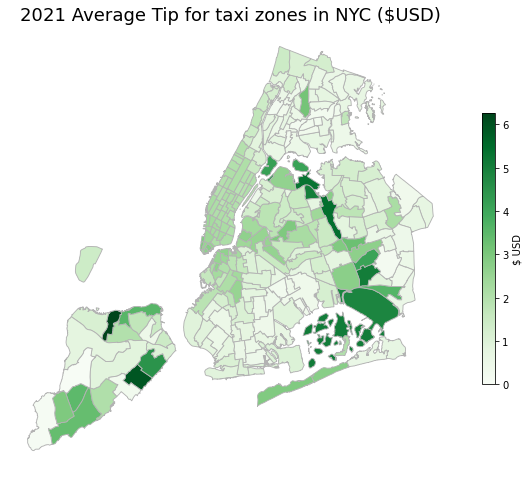

In [22]:
#read shp file
map_and_tip = gpd.read_file("map_and_tip/map_and_tip.shp")

#Plot heat map for the average tips in NY taxi zones
fig, ax = plt.subplots(1, figsize=(10, 10))
map_and_tip.plot(column="tip_avg", cmap="Greens", linewidth=0.9, ax=ax, edgecolor="0.7")

#set bar with red gradient and set minimum and maximum values 
bar_info = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=map_and_tip['tip_avg'].min(), vmax=map_and_tip['tip_avg'].max()))
cbar = fig.colorbar(bar_info,shrink=0.5,label='$ USD')

#set figure tittle and remove axis coordinates
ax.set_title(f'2021 Average Tip for taxi zones in NYC ($USD)',fontsize=18)
ax.set_axis_off()

***Conclusion of part 3:***
According to the map, the best tipper zones are in Port Richmond (6.27 USD), New Dorp (5.92 USD), and Flushing meadows - Corona Park (5.42). Taxi drivers who want higher tips should try to frequent more these zones.

**Part 4: The Tip Distribution by time of day**


In this part, we will discuss on the most time when passengers giving more tips to the yellow taxi drivers.
We will use the yellow taxi data for every months in 2021.
To do that, we will:

1. Get yellow taxi data in 2021 and calculate the percentage of *tip_per_fare* by dividing *tip_amount* over *fare_amount*.
2. By using df.pivot_tables, we will get the average data of tip percentage in every hour in a day.
3. Categorize between weekend and weekdays as there may be the difference between weekdays and weekend people behaviour in giving tip
3. Plot the data and see the tip distribution by the time of day

At the end, the analysis may provide insights for driver "What's the best time to hailing for getting more tips ?

In [30]:
'''
Since the data's size is too big (almost 10Gbs), we have downloaded the data and created pivot tables to be analyzed.
So the code below doesn't need to be run because it will take a long time.
'''

# Merge data from downloaded months csv
df_tipoftheday = pd.DataFrame()

for year in range(2021,2022):
    # Checks if the year data folder exists before looping
    if os.path.exists(f"data/{year}"):
        for month in range(1,13):
            month_str = months[month-1]
            # Check that the month data csv file exists before reading the csv (opening a non-existent file causes errors)
            if os.path.exists(f"data/{year}/{month_str}.csv"):
                cMonthData = pd.read_csv(f"data/{year}/{month_str}.csv")
                cMonthData["hour"] = pd.to_datetime(cMonthData['tpep_pickup_datetime']).dt.hour
                cMonthData["day"] = pd.to_datetime(cMonthData['tpep_pickup_datetime']).dt.weekday
                cMonthData["month"] = pd.to_datetime(cMonthData['tpep_pickup_datetime']).dt.month
                df_tipoftheday = pd.concat([df_tipoftheday, cMonthData])

# Add column tip/fare
df_tipoftheday['tip_per_fare'] = df_tipoftheday['tip_amount']/ df_tipoftheday['fare_amount']

# Remove NaN because of tip/fare calculation
df_tipoftheday = df_tipoftheday[~df_tipoftheday.isin([np.nan, np.inf, -np.inf]).any(1)]

# df_tipoftheday = df_tipoftheday[(df_tipoftheday['tip_per_fare'] > df_tipoftheday['tip_per_fare'].quantile(0.005)) & (df_tipoftheday['tip_per_fare'] < df_tipoftheday['tip_per_fare'].quantile(0.995))]

# Categorize between weekdays and weekend
df_tipoftheday['weekdays_weekend'] = np.where(df_tipoftheday['day'] > 4, "Weekend", "Weekday")

# pivot tables by averaging values per hour and per day for 3 years of data and put in under variables
pivot_tip_weekend_weekdays = df_tipoftheday.pivot_table('tip_per_fare', index='hour', columns='weekdays_weekend', aggfunc='mean')
pivot_tip_weekend_weekdays.to_csv('pivot_tip_weekend_weekdays.csv', index=False)

Text(19.3, 0.2236430827719862, '22%(Highest Tips on Weekdays)')

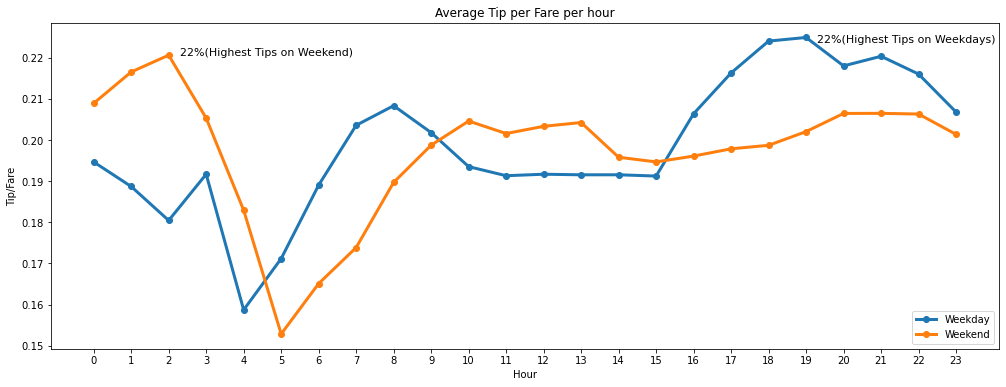

In [31]:
#Open Pivot Table from the last data processing
pivot_tip_weekend_weekdays = pd.read_csv('pivot_tip_weekend_weekdays.csv', index_col = False)

# Create plot for weekend and weekdays
fig, ax = plt.subplots()
fig.set_size_inches(17, 6)

ax.plot(pivot_tip_weekend_weekdays,'-o', linewidth=3)
ax.set(xticks=pivot_tip_weekend_weekdays.index,xlabel='Hour', ylabel = 'Tip/Fare', title = 'Average Tip per Fare per hour')
ax.legend(loc='lower right', labels=pivot_tip_weekend_weekdays.columns)

ax.annotate(f"{pivot_tip_weekend_weekdays['Weekend'].max():.0%}(Highest Tips on Weekend)", xy=(2, pivot_tip_weekend_weekdays['Weekend'].max()), xytext=(2.3, pivot_tip_weekend_weekdays['Weekend'].max()), fontsize=11)
ax.annotate(f"{pivot_tip_weekend_weekdays['Weekday'].max():.0%}(Highest Tips on Weekdays)", xy=(19, pivot_tip_weekend_weekdays['Weekday'].max()), xytext=(19.3, pivot_tip_weekend_weekdays['Weekend'].max()+0.003),fontsize=11)

From the visualization above, we found that the passenger tips behaviour differ between weekdays and weekend. In addition, there are some interesting things which are:
1. The highest tips on average in weekdays is on <kbd>7 PM</kbd>, about <kbd>22%</kbd> of fare amount
2. The highest tips on average in weekend is on <kbd>2 AM</kbd>, about <kbd>22%</kbd> of fare amount.
3. The lowest tips on weekdays and weekend is around <kbd>4 AM and 5 AM</kbd>.
4. <kbd>Between 12 AM - 4 AM</kbd>, passengers give more tips on the weekend than on the weekdays. 
5. <kbd>Between 5 AM - 9 AM and 4 PM - 11 PM</kbd>, people give more tips on weekdays than on weekend.
6. <kbd>Between 10 AM - 3 PM</kbd>, the average tips on weekend is slightly higher than on weekdays.

Our recomendation for taxi drivers to get more tips is to hail in rush hour on weekdays (especially around 8 AM and around 7 PM) and at dawn on weekend (especially around 2 AM)